# Training BLISS on DC2 Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

### Train the model

In [3]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")
from bliss.main import train
train_dc2_cfg = cfg.copy()


# train(train_dc2_cfg.train)

### PLOTS

##### Load the dc2 image

In [4]:
dc2 = instantiate(train_dc2_cfg.surveys.dc2) # load full dc2 image (without image split)
dc2.prepare_data()

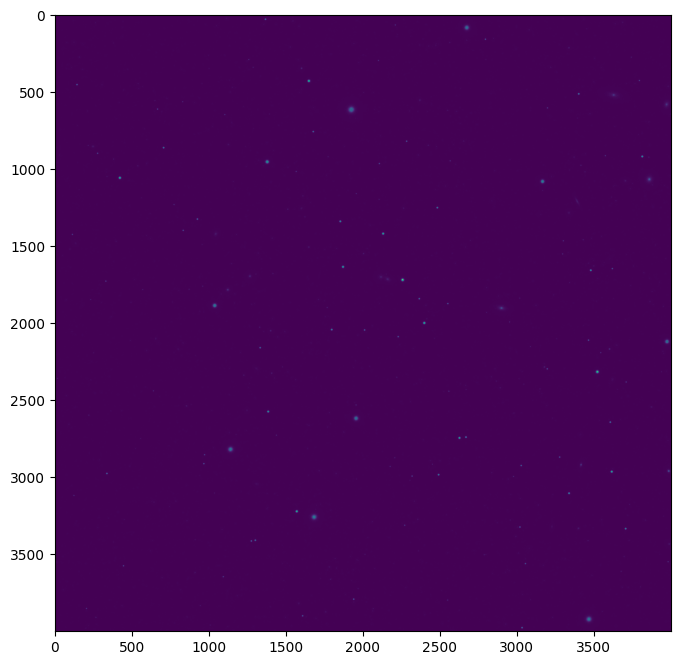

In [5]:
# raw dc2 sky image (160*160)
fig,ax = plt.subplots(figsize=(8, 8))
image = dc2.dc2_data[0]['images'][0]
ax.imshow(np.log((image - image.min())+10), cmap='viridis')

##### Load LSST Catalogs

In [6]:
import GCRCatalogs
GCRCatalogs.set_root_dir("/data/dc2/")
match_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_object_with_truth_match')
match_obj = match_cat.get_quantities(["id_truth", "objectId", "ra", "dec", "truth_type", "cModelFlux_r", "cModelFluxErr_r"])

Match LSST catalog with the dc2 image

In [7]:
wcs = dc2.dc2_data[0]['wcs']

In [8]:
full_cat = dc2.dc2_data[0]['full_catalog']
matchid = dc2.dc2_data[0]['matchid']
wcs = dc2.dc2_data[0]['wcs']
flux = (full_cat["galaxy_fluxes"])[0, :, 2] #r-band
truth_df = pd.DataFrame({'id':full_cat['objid'][0][:, 0], "matchid":matchid,'flux':flux})
lsst_match = pd.DataFrame(match_obj)

truth_df["p0_truth"] = full_cat['plocs'][0][:,0]
truth_df["p1_truth"] = full_cat['plocs'][0][:,1]


# filter the object in the LSST catalog and keep the object in the current dc2 image
ra = torch.tensor(lsst_match['ra'].values)
dec = torch.tensor(lsst_match['dec'].values)

pt, pr = wcs.all_world2pix(ra, dec, 0)
pt = torch.tensor(pt)
pr = torch.tensor(pr)
plocs = torch.stack((pr, pt), dim=-1)
plocs = (plocs.reshape(1, plocs.size()[0], 2))[0]

x0_mask = (plocs[:, 0] > 0) & (plocs[:, 0] < 4000)
x1_mask = (plocs[:, 1] > 0) & (plocs[:, 1] < 4000)
x_mask = x0_mask * x1_mask
plocs = plocs[x_mask]
temp = lsst_match[x_mask.tolist()]

temp['cModelFlux'] = temp['cModelFlux_r'] + temp["cModelFluxErr_r"]
flux_mask = temp['cModelFlux_r']>0
lsst_df = temp[flux_mask]
plocs_lsst = plocs[flux_mask.tolist()]

lsst_df["plocs0"] = plocs_lsst[:, 0]
lsst_df["plocs1"] = plocs_lsst[:, 1]


p0 = lsst_df.dropna()['plocs1']
p1 = lsst_df.dropna()['plocs0']
plocs_lsst = torch.tensor(np.stack((p1, p0), axis = -1))

/tmp/ipykernel_3557858/1804150824.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['cModelFlux'] = temp['cModelFlux_r'] + temp["cModelFluxErr_r"]
/tmp/ipykernel_3557858/1804150824.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsst_df["plocs0"] = plocs_lsst[:, 0]
/tmp/ipykernel_3557858/1804150824.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

##### Load the trained model and make prediction

In [9]:
MODEL_PATH = "/home/lxinyue/origin/bliss/output/DC2/DC2_origin/checkpoints/best_encoder.ckpt"
encoder = instantiate(train_dc2_cfg.encoder)
encoder.load_state_dict(torch.load(MODEL_PATH)["state_dict"])
encoder.eval();


In [10]:
batch = {
    "tile_catalog": dc2.dc2_data[0]['tile_catalog'],
    "images": torch.from_numpy(rearrange(dc2.dc2_data[0]['images'], "h w nw -> 1 h w nw")),
    "background": torch.from_numpy(rearrange(dc2.dc2_data[0]['background'], "h w nw -> 1 h w nw")),
    "psf_params": rearrange(dc2.dc2_data[0]['psf_params'], "h w -> 1 h w")
    }
with torch.no_grad():
    out_dict = encoder.predict_step(batch, None)


In [11]:
bliss_cat = out_dict["mode_cat"]
bliss_cat = bliss_cat.to_full_catalog()
bliss_cat.plocs = bliss_cat.plocs + 4
matcher = instantiate(train_dc2_cfg.encoder.matcher)
metrics = instantiate(train_dc2_cfg.encoder.metrics)
matching = matcher.match_catalogs(dc2.dc2_data[0]['full_catalog'], bliss_cat)
metric = metrics(dc2.dc2_data[0]['full_catalog'], bliss_cat, matching)
metric["detection_recall"], metric["detection_precision"], metric["detection_f1"], metric["classification_acc"]

(tensor(0.8389), tensor(0.9377), tensor(0.8856), 0.992887020111084)

##### Plots

In [12]:
# could use macher for bliss catalog and truth catalog
# this function (match_by_locs) is for matching the lsst detection location and truth object location
from einops import rearrange, reduce
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
def match_by_locs(true_locs, est_locs, slack=1.0):
    """Match true and estimated locations and returned indices to match.

    Permutes `est_locs` to find minimal error between `true_locs` and `est_locs`.
    The matching is done with `scipy.optimize.linear_sum_assignment`, which implements
    the Hungarian algorithm.

    Automatically discards matches where at least one location has coordinates **exactly** (0, 0).

    Args:
        slack: Threshold for matching objects a `slack` l-infinity distance away (in pixels).
        true_locs: Tensor of shape `(n1 x 2)`, where `n1` is the true number of sources.
            The centroids should be in units of PIXELS.
        est_locs: Tensor of shape `(n2 x 2)`, where `n2` is the predicted
            number of sources. The centroids should be in units of PIXELS.

    Returns:
        A tuple of the following objects:
        - row_indx: Indicies of true objects matched to estimated objects.
        - col_indx: Indicies of estimated objects matched to true objects.
        - dist_keep: Matched objects to keep based on l1 distances.
        - avg_distance: Average l-infinity distance over all matched objects.
        - avg_keep_distance: Average l-infinity distance over matched objects to keep.
    """
    assert len(true_locs.shape) == len(est_locs.shape) == 2
    assert true_locs.shape[-1] == est_locs.shape[-1] == 2
    assert isinstance(true_locs, torch.Tensor) and isinstance(est_locs, torch.Tensor)

    # reshape
    locs1 = true_locs.view(-1, 2)
    locs2 = est_locs.view(-1, 2)

    locs_abs_diff = (rearrange(locs1, "i j -> i 1 j") - rearrange(locs2, "i j -> 1 i j")).abs()
    locs_err = reduce(locs_abs_diff, "i j k -> i j", "sum")
    locs_err_l_infty = reduce(locs_abs_diff, "i j k -> i j", "max")

    # Penalize all pairs which are greater than slack apart to favor valid matches.
    locs_err = locs_err + (locs_err_l_infty > slack) * locs_err.max()

    # add small constant to avoid 0 weights (required for sparse bipartite matching)
    locs_err += 0.001

    # convert light source error matrix to CSR
    csr_locs_err = csr_matrix(locs_err.detach().cpu())

    # find minimal permutation and return matches
    row_indx, col_indx = min_weight_full_bipartite_matching(csr_locs_err)

    # only match objects that satisfy threshold on l-infinity distance.
    dist = (locs1[row_indx] - locs2[col_indx]).abs().max(1)[0]

    # GOOD match condition: L-infinity distance is less than slack
    dist_keep = (dist < slack).bool()
    avg_distance = dist.mean()
    avg_keep_distance = dist[dist < slack].mean()

    if dist_keep.sum() > 0:
        assert dist[dist_keep].max() <= slack

    return row_indx, col_indx, dist_keep.cpu().numpy(), avg_distance, avg_keep_distance, dist


(array([7.677e+03, 2.848e+03, 1.482e+03, 8.830e+02, 5.820e+02, 4.580e+02,
        3.270e+02, 2.330e+02, 1.840e+02, 1.670e+02, 1.480e+02, 1.340e+02,
        1.240e+02, 8.900e+01, 8.400e+01, 8.600e+01, 8.600e+01, 6.400e+01,
        6.300e+01, 6.500e+01, 6.500e+01, 4.800e+01, 4.500e+01, 4.600e+01,
        3.300e+01, 3.000e+01, 3.000e+01, 3.900e+01, 3.400e+01, 2.700e+01,
        2.400e+01, 2.200e+01, 2.800e+01, 2.000e+01, 2.300e+01, 1.300e+01,
        2.000e+01, 2.000e+01, 1.400e+01, 1.500e+01, 1.900e+01, 2.300e+01,
        1.400e+01, 1.300e+01, 1.500e+01, 1.300e+01, 1.400e+01, 1.900e+01,
        4.000e+00, 9.000e+00, 1.400e+01, 1.400e+01, 6.000e+00, 1.300e+01,
        9.000e+00, 1.500e+01, 6.000e+00, 6.000e+00, 8.000e+00, 3.000e+00,
        8.000e+00, 8.000e+00, 3.000e+00, 1.000e+01, 6.000e+00, 3.000e+00,
        1.000e+00, 7.000e+00, 2.000e+00, 7.000e+00, 3.000e+00, 5.000e+00,
        3.000e+00, 6.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 0.000e+0

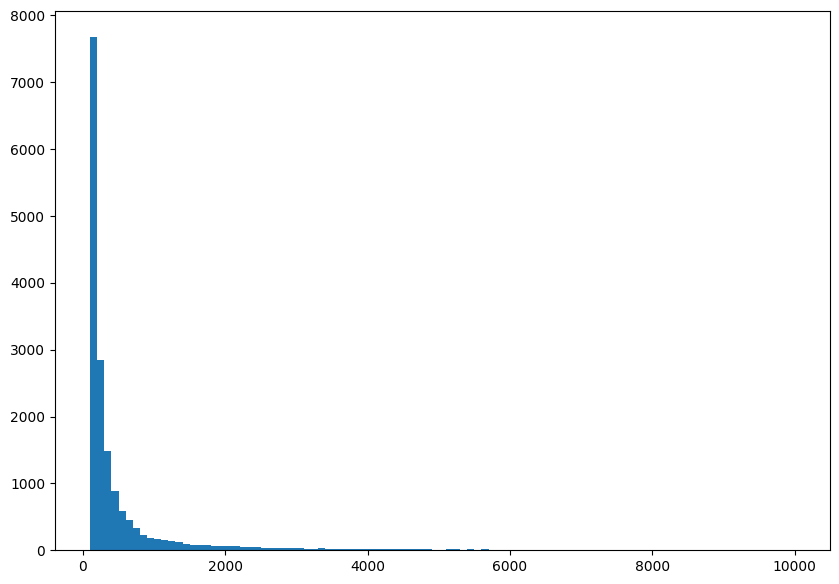

In [13]:
# galaxy flux distribution
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(full_cat.to_dict()["galaxy_fluxes"][0][:, 2], np.linspace(100, 10000, num=100))

In [14]:
#compute detection distance
row_bliss, col_bliss, bliss_dkeep, avg_distance, avg_keep_distance, bliss_dist = match_by_locs(full_cat.plocs[0], bliss_cat.plocs[0])
bliss_flux = bliss_cat.to_dict()["galaxy_fluxes"]*bliss_cat.galaxy_bools+bliss_cat.to_dict()["star_fluxes"]*bliss_cat.star_bools
bliss_df = pd.DataFrame({"flux":bliss_flux[0,:, 2].numpy(), "dist":bliss_dist.numpy()})

In [15]:
row_lsst, col_lsst, lsst_dkeep, avg_distance, avg_keep_distance, lsst_dist = match_by_locs(full_cat.plocs[0], plocs_lsst)
full_df = pd.DataFrame({'id':full_cat['objid'][0][:, 0], 'matchid':dc2.dc2_data[0]['matchid'], 'flux':flux})
df_lsst = pd.DataFrame({"flux": full_df['flux'], "dist": lsst_dist})

Text(0, 0.5, 'Distance')

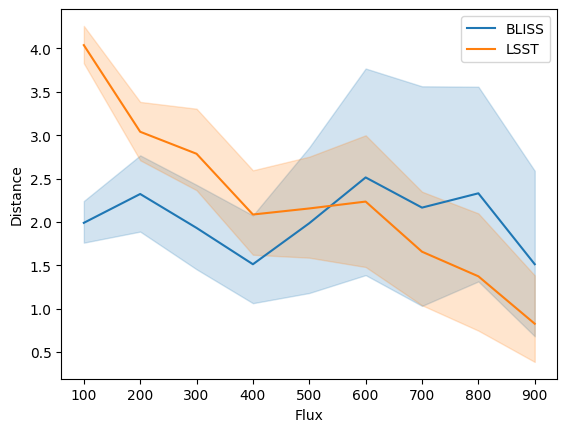

In [16]:
# Generate bin intervals
bins = np.linspace(100, 1000, num=10)
bliss_df['bins'] = pd.cut(bliss_df['flux'], bins).apply(lambda x: x.left)
df_lsst['bins'] = pd.cut(df_lsst['flux'], bins).apply(lambda x: x.left)
sns.lineplot(x=bliss_df["bins"], y=bliss_df["dist"], label = "BLISS")
sns.lineplot(x=df_lsst["bins"], y=df_lsst["dist"], label = "LSST")
plt.xlabel("Flux")
plt.ylabel("Distance")

In [17]:
met = {"lsst_recall":[], "bliss_recall":[], "bliss_tp": [], "lsst_tp": [], "truth":[]}
i = 0
df_full = pd.DataFrame({'id':full_cat['objid'][0][:, 0], "matchid":matchid,'flux':flux})

df_full["p0_truth"] = full_cat['plocs'][0][:,0]
df_full["p1_truth"] = full_cat['plocs'][0][:,1]
for f_lim in bins:
    df_full_temp = df_full[(df_full['flux']>f_lim)]
    truth_flux = df_full_temp[(df_full_temp['flux']<f_lim+100)]
    p0_true = truth_flux['p0_truth']
    p1_true = truth_flux['p1_truth']
    plocs_truth = torch.tensor(np.stack((p0_true, p1_true), axis = -1))
    
    # pred_flux = df_match[df_match['cModelFlux_r']>100]
    truth_obj = truth_flux.merge(lsst_df, left_on = "matchid", right_on = "objectId", how = "left" )
    p0 = truth_obj.dropna()['plocs0']
    p1 = truth_obj.dropna()['plocs1']
    lsst_plocs = torch.tensor(np.stack((p0, p1), axis = -1))
    _, _, lsst_dkeep, _, _, _ = match_by_locs(plocs_truth, lsst_plocs, slack=1.0)

    ntrue = truth_flux.shape[0]
    # nest = plocs.shape[0]
    tp = lsst_dkeep.sum().item()
    detection_tp = tp
    # detection_fp = nest - tp

    # precision = detection_tp / (detection_tp + detection_fp)
    met["lsst_tp"].append(tp)
    lsst_recall = detection_tp / ntrue
    met["lsst_recall"].append(lsst_recall)
    # f1 = 2 * precision * recall / (precision + recall)
    
    _, _, bliss_dkeep, _, _, _ = match_by_locs(plocs_truth, bliss_cat["plocs"][0], slack=1.0)

    ntrue = truth_flux.shape[0]
    # nest = plocs.shape[0]
    tp = bliss_dkeep.sum().item()
    detection_tp = tp
    # detection_fp = nest - tp
    
    met["bliss_tp"].append(tp)
    met["truth"].append(ntrue)

    # precision = detection_tp / (detection_tp + detection_fp)
    bliss_recall = (detection_tp / ntrue)
    met["bliss_recall"].append(bliss_recall if bliss_recall <= 1 else 1)

    i = i+1

/tmp/ipykernel_3557858/2097500965.py:28: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(ylims2)


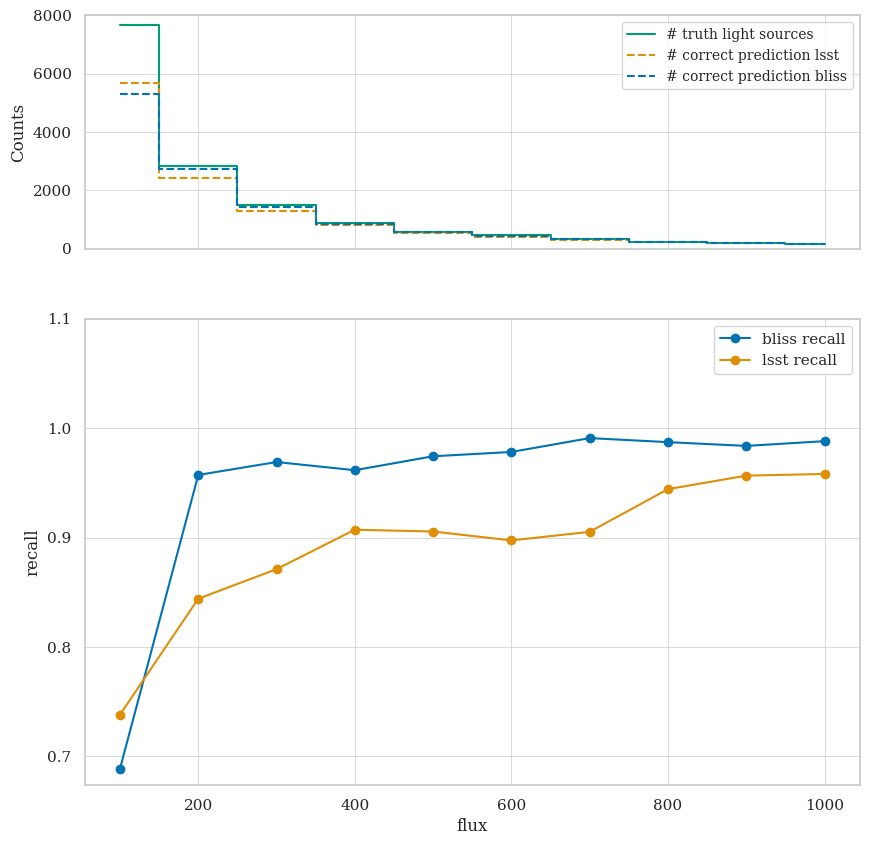

In [18]:
import seaborn as sns
sns.set_theme(style='whitegrid', palette='colorblind', font='serif')
data = pd.DataFrame(met, columns=["lsst_recall", "bliss_recall", "bliss_tp", "lsst_tp", "truth"])
ymin = data.min().min()
yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 2]}, sharex=True
)
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
ax2.plot(bins, data["bliss_recall"], "-o", color=c1, label=r"bliss recall", markersize=6)
ax2.plot(bins, data["lsst_recall"], "-o", color=c2, label=r"lsst recall", markersize=6)

ax2.legend()
ax2.set_xlabel("flux")
ax2.set_ylabel("recall")
ax2.set_yticks(yticks)
ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

xlims = None
ylims = None
ylims2 = 1
if xlims is not None:
    ax2.set_xlim(xlims)
if ylims is not None:
    ax2.set_ylim(ylims)
if ylims2 is not None:
    ax1.set_ylim(ylims2)

where_step = "mid"
n_ticks = 5
ordmag = 3
legend_size_hist = 10

c3 = plt.rcParams["axes.prop_cycle"].by_key()["color"][2]
ax1.step(bins, data["truth"], label="# truth light sources", where=where_step, color=c3)
ax1.step(bins, data["lsst_tp"], label="# correct prediction lsst", ls="--", where=where_step, color=c2)
ax1.step(bins, data["bliss_tp"], label="# correct prediction bliss", ls="--", where=where_step, color=c1)
ymax = data.max().max()
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax1.set_yticks(yticks)
ax1.set_ylabel(r"Counts")
ax1.legend(loc="best", prop={"size": legend_size_hist})
ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

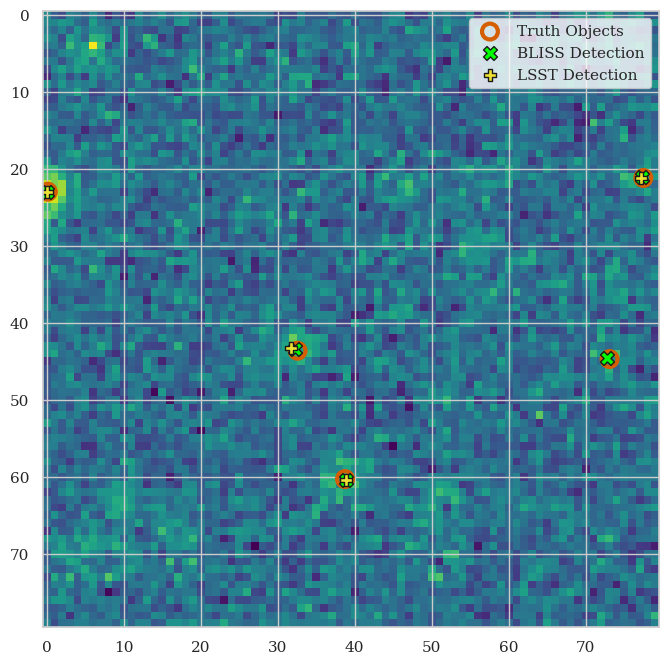

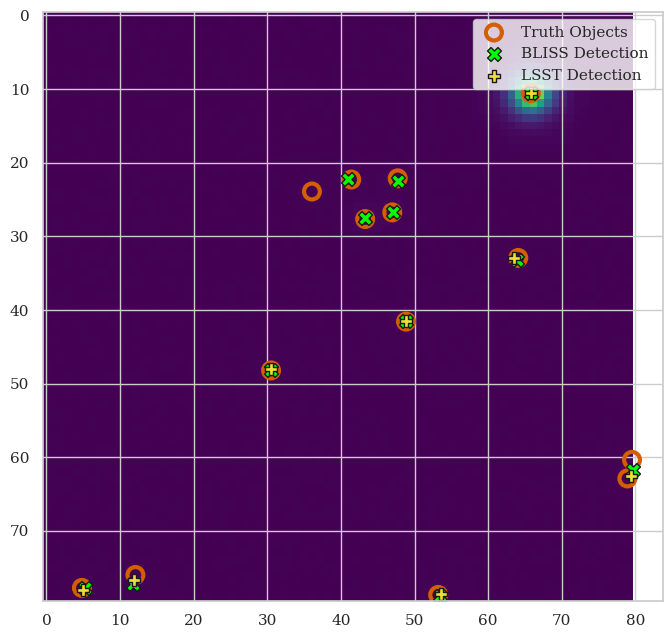

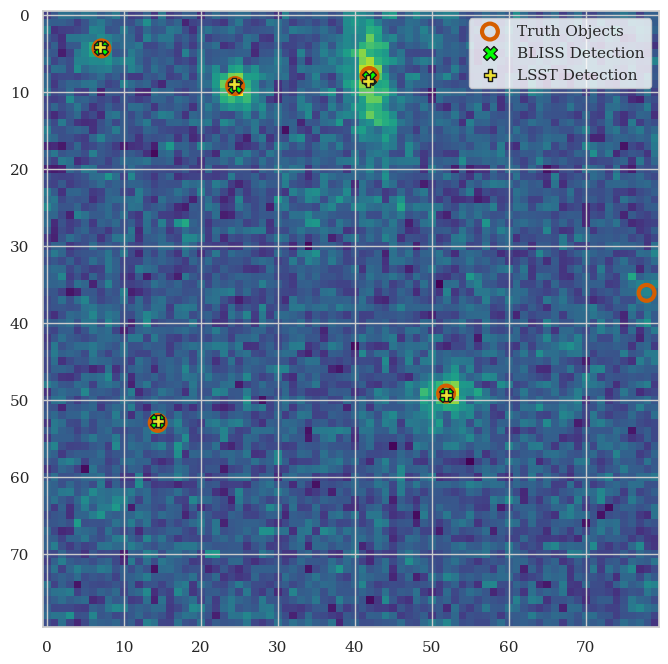

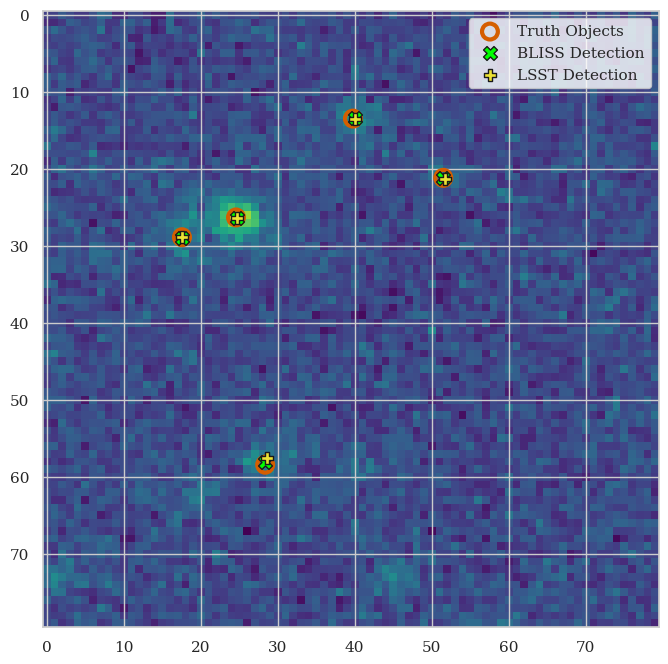

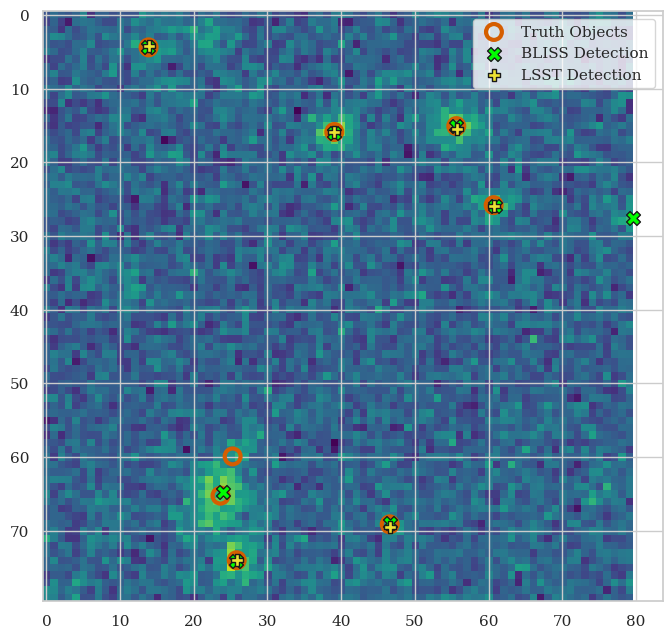

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# random 5 plots, to show the bliss and lsst detection performance, compared with the truth objects
for i in range(5, 10):
    lim1 = i*100
    lim2 = lim1 +80
    truth_plocs = full_cat.plocs[0]
    x0_mask = (truth_plocs[:, 0] > lim1) & (truth_plocs[:, 0] < lim2)
    x1_mask = (truth_plocs[:, 1] > lim1) & (truth_plocs[:, 1] < lim2)
    x_mask_1 = x0_mask * x1_mask

    bliss_plocs = bliss_cat['plocs'][0]
    x0_mask = (bliss_plocs[:,1] > lim1) & (bliss_plocs[:,1] < lim2)
    x1_mask = (bliss_plocs[:,0] > lim1) & (bliss_plocs[:,0] < lim2)
    x_mask_2 = x0_mask * x1_mask

    # run our matching algorithm (instead of using lsst's matching)
    row_lsst, col_lsst, lsst_dkeep, avg_distance, avg_keep_distance, lsst_dist = match_by_locs(full_cat['plocs'][0][x_mask_1], plocs_lsst)
    plocs_lsst_temp = plocs_lsst[col_lsst][lsst_dkeep]
    x0_mask = (plocs_lsst_temp[:,1] > lim1) & (plocs_lsst_temp[:,1] < lim2)
    x1_mask = (plocs_lsst_temp[:,0] > lim1) & (plocs_lsst_temp[:,0] < lim2)
    x_mask_3 = x0_mask * x1_mask
    plocs = full_cat['plocs'][0]
    fig,ax = plt.subplots(figsize=(8, 8))
    b = dc2.dc2_data[0]
    image_small = b['images'][0][lim1:lim2, lim1:lim2]
    ax.imshow(np.log((image_small - image_small.min())+80), cmap='viridis')
    ax.scatter(plocs[:,1][x_mask_1]-lim1, plocs[:,0][x_mask_1]-lim1, facecolors='none', edgecolors='r', alpha = 1, s=130, linewidth=3, label = "Truth Objects")
    ax.scatter(bliss_cat['plocs'][0][:,1][x_mask_2]-lim1, bliss_cat['plocs'][0][:,0][x_mask_2]-lim1, marker = 'X',facecolors='lime', edgecolors='k', alpha = 1, s = 100, linewidth=1, label="BLISS Detection")
    ax.scatter(plocs_lsst_temp[:,1][x_mask_3]-lim1, plocs_lsst_temp[:,0][x_mask_3]-lim1, marker = 'P', facecolors='y', edgecolors='k', alpha = 1, s = 80,linewidth=1, label="LSST Detection")

    ax.legend()

In [20]:
# Galaxy error plots
tcat_matches, ecat_matches = matching[0]
true_gp = full_cat["galaxy_params"][0, tcat_matches, :]
est_gp = bliss_cat["galaxy_params"][0, ecat_matches, :]
gp_err = true_gp - est_gp
df = pd.DataFrame({
    "flux": full_cat["galaxy_fluxes"][0, tcat_matches, :][:, 2],
    "disk_frac":gp_err[:, 0],
    "beta_radians":gp_err[:, 1],
    "disk_q":gp_err[:, 2],
    "a_d":gp_err[:, 3],
    "bulge_q":gp_err[:, 4],
    "a_b":gp_err[:, 5]})

Text(0, 0.5, 'beta_radians')

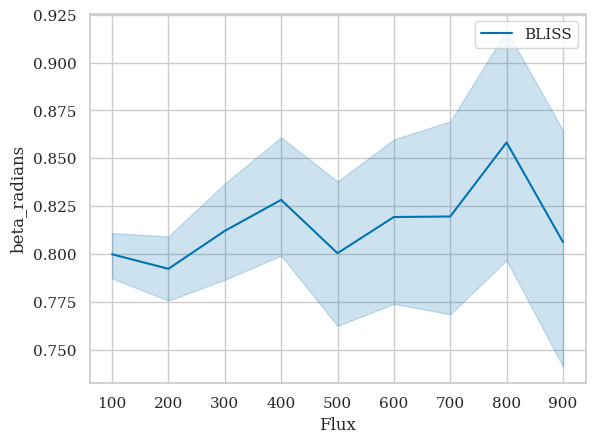

In [21]:
df['bins'] = pd.cut(df['flux'], bins).apply(lambda x: x.left)
sns.lineplot(x=df["bins"], y=abs(df["beta_radians"]), label = "BLISS")
plt.xlabel("Flux")
plt.ylabel("beta_radians")

Text(0, 0.5, 'a_d')

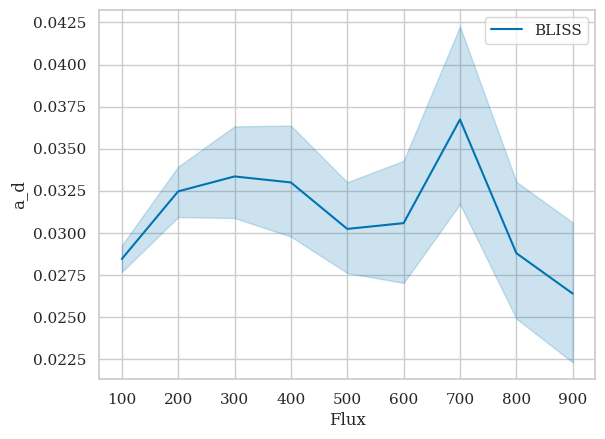

In [22]:
df['bins'] = pd.cut(df['flux'], bins).apply(lambda x: x.left)
sns.lineplot(x=df["bins"], y=abs(df["a_d"]), label = "BLISS")
plt.xlabel("Flux")
plt.ylabel("a_d")

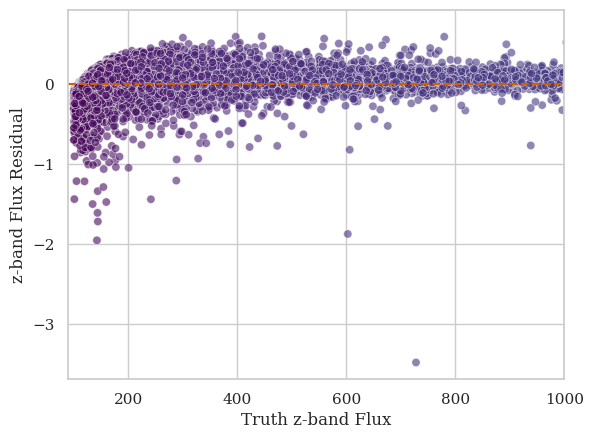

In [23]:
# flux error
true_flux = full_cat.on_fluxes[0, tcat_matches, :]
est_flux = bliss_cat.on_fluxes[0, ecat_matches, :]
flux_err = true_flux - est_flux
i = 2
est_band_flux = est_flux[:,i]
true_band_flux = true_flux[:,i]
res = flux_err[:,i]/true_band_flux
sns.scatterplot(
    x = np.array(true_band_flux), 
    y = np.array(res), 
    alpha = 0.6,
    c = np.log(true_flux[:,2]), 
    cmap = "viridis"
)
plt.xlim(90, 1000)
plt.ylabel('z-band Flux Residual')
plt.xlabel('Truth z-band Flux')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()